<a href="https://colab.research.google.com/github/amilkh/cs230-fer/blob/saliency/fer2013_grad_cam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import *
import PIL 
from tensorflow.keras import backend as K
from tensorflow.keras import Model
import cv2
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/My Drive/cs230 project/collab/fer2013/fer2013.csv')

#print('Number of samples in the dataset: ', data.shape[0])
# Transform images from strings to lists of integers. TODO: use an array cast
data['pixels'] = data['pixels'].apply(lambda x: [int(pixel) for pixel in x.split()])

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
emotion_cat = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

In [0]:
data_train = data[data['Usage']=='Training']
data_dev = data[data['Usage']=='PublicTest']

# Retrieve train input and target
X_train, y_train = data_train['pixels'].tolist(), data_train['emotion'].values
# Reshape images to 4D (num_samples, width, height, num_channels)
X_train = np.array(X_train, dtype='float32').reshape(-1,48,48,1)
# Normalize images with max (the maximum pixel intensity is 255)
X_train = X_train/255.0

# Retrieve dev input and target
X_dev, y_dev = data_dev['pixels'].tolist(), data_dev['emotion'].values
X_dev = np.array(X_dev, dtype='float32').reshape(-1,48,48,1)
X_dev = X_dev/255.0

In [7]:
#Baseline model
model = tf.keras.models.Sequential([
    InputLayer(input_shape=(48,48,1),name="input"),
    Conv2D(filters=32,kernel_size=3,activation='relu',padding='same',name="conv1"),
    Conv2D(filters=32,kernel_size=3,activation='relu',padding='same',name="conv2"),
    MaxPool2D(pool_size=(2,2),name="maxpool1"),
    Conv2D(filters=64,kernel_size=3,activation='relu',padding='same',name="conv3"),
    Conv2D(filters=64,kernel_size=3,activation='relu',padding='same',name="conv4"),
    Flatten(),
    Dense(1024,input_shape=(64*24*24,1), activation='relu', name='fc-1' ),
    Dense(7,input_shape=(64,1),activation='softmax',name='fc-softmax')
])

print("Accuracy after training")
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Accuracy after training


In [8]:
model.fit(X_train,y_train,batch_size=32,epochs=3,validation_data=(X_dev, y_dev))

Train on 28709 samples, validate on 3589 samples
Epoch 1/3
28709/28709 [==============================] - 21s 742us/sample - loss: 1.6313 - accuracy: 0.3546 - val_loss: 1.4420 - val_accuracy: 0.4469
Epoch 2/3
28709/28709 [==============================] - 14s 478us/sample - loss: 1.3647 - accuracy: 0.4746 - val_loss: 1.3159 - val_accuracy: 0.4918
Epoch 3/3
28709/28709 [==============================] - 14s 479us/sample - loss: 1.1338 - accuracy: 0.5739 - val_loss: 1.2799 - val_accuracy: 0.5199


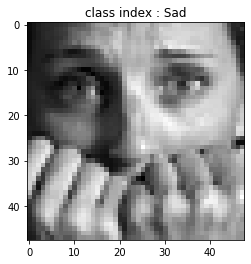

In [9]:
# Select an image to show the saliency map on
indx=56
plt.title(label = "class index : {}".format(emotion_cat[y_dev[indx]]))
plt.imshow(X_dev[indx].reshape(48,48),cmap='gray')
target_image = X_dev[indx].reshape(1,48,48,1)

# Gradient Class activation maps

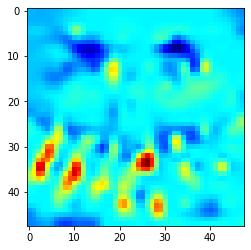

In [19]:
single_example =  X_dev[indx]
label = int(y_dev[indx])

LAST_LAYER = "conv4"
grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAST_LAYER).output, model.output])

with tf.GradientTape() as tape:
    conv_outputs, preds = grad_model(single_example.reshape(1, 48, 48, 1 ))
    loss = preds[:,y_dev[indx]]

output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]
weights = tf.reduce_mean(grads, axis=(0, 1))
cam = np.ones(output.shape[0: 2], dtype = np.float32)
for i, w in enumerate(weights):
    cam += w * output[:, :, i]
cam = cv2.resize(cam.numpy(), (48, 48))
heatmap = (cam - cam.min()) / (cam.max() - cam.min())

cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

plt.imshow(cam,cmap='gray')

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 48, 48, 32)        320       
_________________________________________________________________
conv2 (Conv2D)               (None, 48, 48, 32)        9248      
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 24, 24, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 24, 24, 64)        18496     
_________________________________________________________________
conv4 (Conv2D)               (None, 24, 24, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 36864)             0         
_________________________________________________________________
fc-1 (Dense)                 (None, 1024)              3